In [41]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

In [22]:
# importam date 
dataset_url = r'C:\Users\denis\Desktop\cppsm\EuroSat\2750'

dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, batch_size=10)

data_sample = dataset.take(5)

Found 27000 files belonging to 10 classes.


In [23]:
for img, label in dataset_sample:
    print(img.shape, label)

(10, 64, 64, 3) tf.Tensor([5 1 0 2 7 1 2 9 6 1], shape=(10,), dtype=int32)
(10, 64, 64, 3) tf.Tensor([2 7 5 9 3 2 7 4 3 6], shape=(10,), dtype=int32)
(10, 64, 64, 3) tf.Tensor([1 1 4 0 8 5 1 4 2 0], shape=(10,), dtype=int32)
(10, 64, 64, 3) tf.Tensor([5 5 4 8 0 0 1 6 2 0], shape=(10,), dtype=int32)
(10, 64, 64, 3) tf.Tensor([4 8 6 1 0 1 1 1 1 1], shape=(10,), dtype=int32)


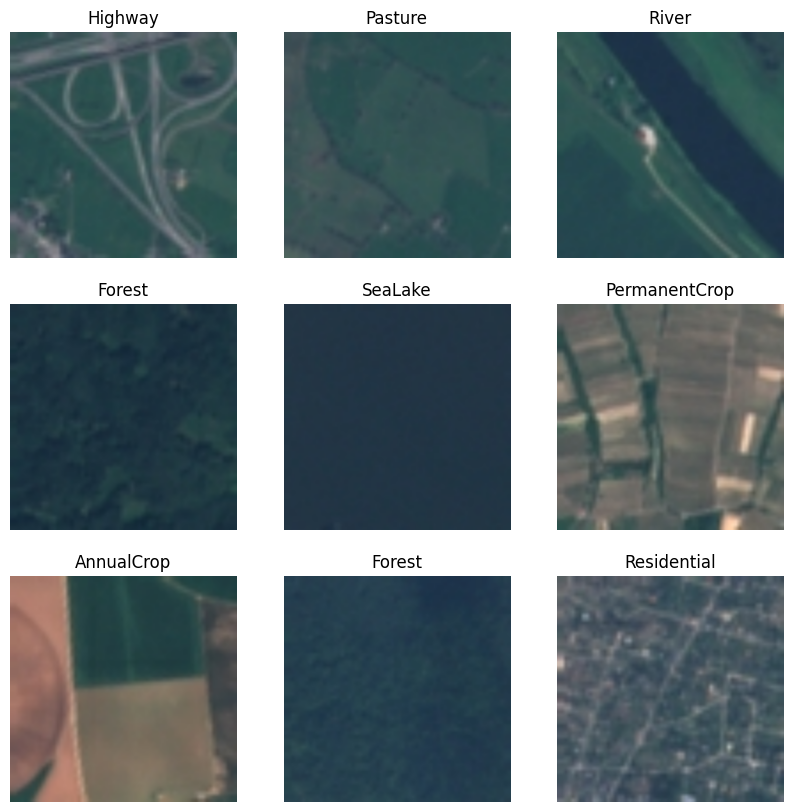

In [52]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Imagine: (64, 64, 3) Etichetă: 0


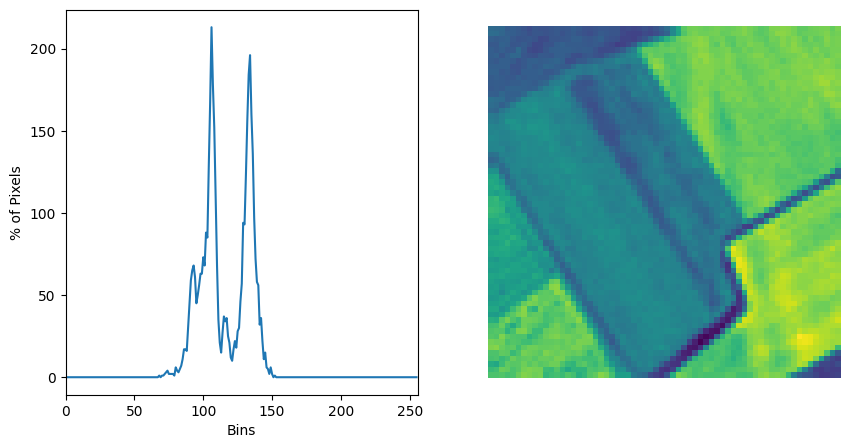

In [40]:
for images, labels in dataset_sample.take(1):
    for img, label in zip(images, labels):
        print("Imagine:", img.shape, "Etichetă:", label.numpy())
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.figure(figsize=(10, 5))

        plt.subplot(1,2,1)
        plt.xlabel("Bins")
        plt.ylabel("% of Pixels")
        plt.plot(hist)
        plt.xlim([0,256])
        
        plt.subplot(1,2,2)
        plt.imshow(img)
        plt.axis('off')
        
        plt.show()
        break


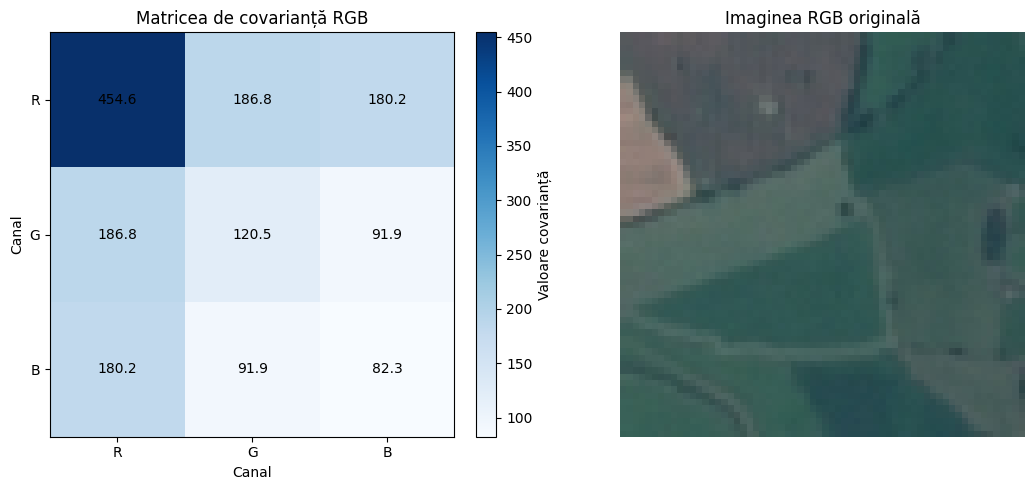

In [48]:
for images, labels in dataset_sample.take(1):
    for img, label in zip(images, labels):
        img = np.array(img, dtype=float)

# 2. Separăm canalele
        R = img[:, :, 0].flatten()
        G = img[:, :, 1].flatten()
        B = img[:, :, 2].flatten()
        
        # 3. Creăm matricea X: fiecare coloană = un canal
        X = np.stack((R, G, B), axis=0)
        
        # 4. Calculăm matricea de covarianță
        cov_matrix = np.cov(X)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # ---- Stânga: Matricea de covarianță ----
        labels = ['R', 'G', 'B']
        im = axes[0].imshow(cov_matrix, cmap='Blues')
        axes[0].set_xticks(np.arange(len(labels)))
        axes[0].set_yticks(np.arange(len(labels)))
        axes[0].set_xticklabels(labels)
        axes[0].set_yticklabels(labels)
        axes[0].set_title("Matricea de covarianță RGB")
        axes[0].set_xlabel("Canal")
        axes[0].set_ylabel("Canal")
        
        # Afișăm valorile numerice în fiecare celulă
        for i in range(len(labels)):
            for j in range(len(labels)):
                axes[0].text(j, i, f"{cov_matrix[i, j]:.1f}",
                             ha='center', va='center', color='black', fontsize=10)
        
        fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04, label="Valoare covarianță")
        
        # ---- Dreapta: Imaginea RGB ----
        axes[1].imshow(img.astype(np.uint8))
        axes[1].set_title("Imaginea RGB originală")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

        break